In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_gp
import time
import numpy as np
import cupy as cp
import multiprocess
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import ariel_numerics
import ariel_load

local


In [2]:
train_data = kgs.load_all_train_data()
print(len(train_data))

1099


In [3]:
# FGS = []
# AIRS = []
# N_FGS=2500
# N_AIRS=250
# loaders = ariel_load.default_loaders()
# raise 'deal with masking'
# for d in tqdm(train_data):
#     for t in d.transits:
#         tt = copy.deepcopy(t)
#         tt.load_to_step(2, d, loaders)
#         for ii in range(tt.data[0].data.shape[0]//N_FGS):
#             FGS.append(cp.mean(tt.data[0].data[N_FGS*ii:(N_FGS)*(ii+1),...],0).get())
#         for ii in range(tt.data[1].data.shape[0]//N_AIRS):
#             AIRS.append(cp.mean(tt.data[1].data[N_AIRS*ii:(N_AIRS)*(ii+1),...],0).get())
# del tt
# FGS = cp.array(FGS)
# AIRS = cp.array(AIRS)
# data = [FGS, AIRS]
# kgs.dill_save(kgs.temp_dir + '/explore_bad_pixels.pickle', data)
# del data


In [4]:
# data_modes = kgs.dill_load(kgs.temp_dir + '/explore_bad_pixels.pickle')
# for ii in range(data_modes[1].shape[1]):
#     for jj in range(data_modes[1].shape[2]):
#         if cp.all(cp.isnan(data_modes[1][:,ii,jj])):
#             data_modes[1][:,ii,jj] = data_modes[1][:,ii,jj+1]/2 + data_modes[1][:,ii,jj-1]/2
# import importlib
# importlib.reload(ariel_numerics)
# n_components = [10]+[5]*282
# S = []
# components = []
# weights = []
# for i_wavelength in tqdm(range(0,283,1)):
#     if i_wavelength==0:
#         this_data = copy.deepcopy(data_modes[0].reshape(-1,1024))
#     else:
#         this_data = copy.deepcopy(data_modes[1][:,:,i_wavelength-1])
#     #print(i_wavelength, end =" ")
#     dat = this_data
#     S.append([]);components.append([]);weights.append([])
#     for ii in range(n_components[i_wavelength]):
#         this_weights, this_components, this_S = ariel_numerics.nan_pca(dat, 1, tol=1e-1, verbose=False)
#         #print(this_S)
#         #dat = dat - weights[:,0][:,None,None]*components[0,:][None,:,:]
#         dat -= this_weights * this_components
#         S[-1].append(this_S)
#         components[-1].append(this_components)
#         weights[-1].append(this_weights)
#         #plt.figure();plt.semilogy(S.get())
#         #weights,components,S = ariel_numerics.nan_pca(data_residual, 4, tol=1e-1, verbose=True)
#         #plt.figure();plt.semilogy(S.get())
#         #weights,components,S = ariel_numerics.nan_pca(data_residual, 5, tol=1e-1, verbose=True)
#     S[-1]=cp.array(S[-1])[:,0]
# kgs.dill_save(kgs.temp_dir + '/explore_bad_pixels_pca.pickle', (S,components,weights))
S,components,weights = kgs.dill_load(kgs.temp_dir + '/explore_bad_pixels_pca.pickle')
data_modes = kgs.dill_load(kgs.temp_dir + '/explore_bad_pixels.pickle')

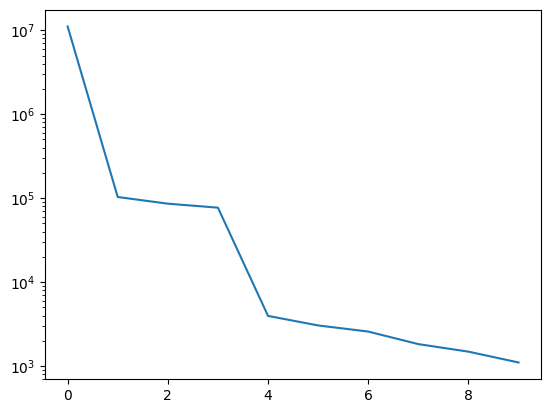

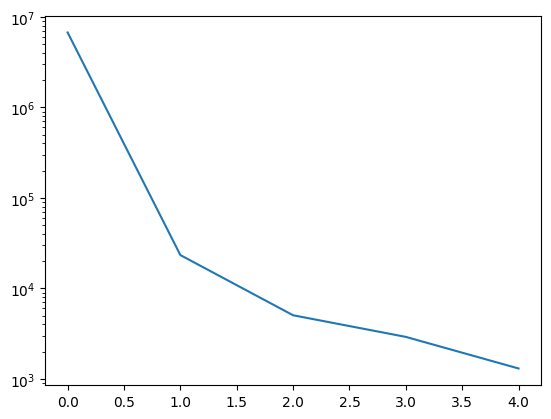

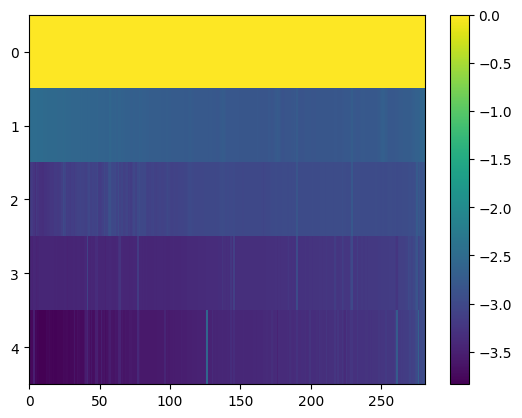

In [5]:
plt.figure()
plt.semilogy(S[0].get())
plt.figure()
plt.semilogy(S[1].get())
plt.figure()
SS = cp.stack(S[1:]).T
SS = SS/SS[0,:]
plt.imshow(cp.log(SS).get()/np.log(10), aspect='auto', interpolation='none')
plt.colorbar()

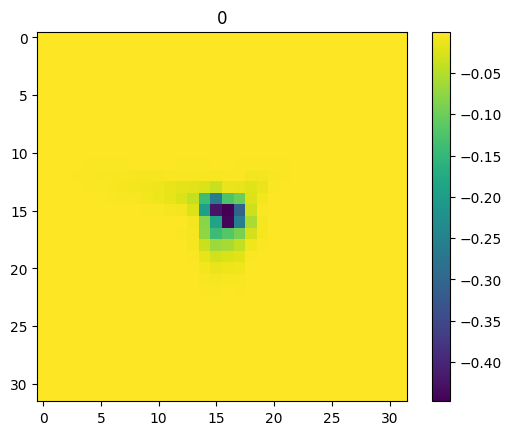

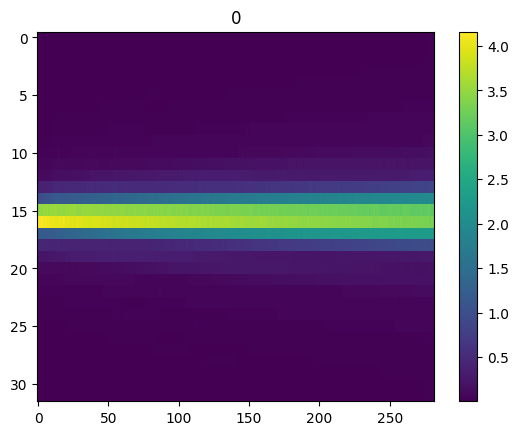

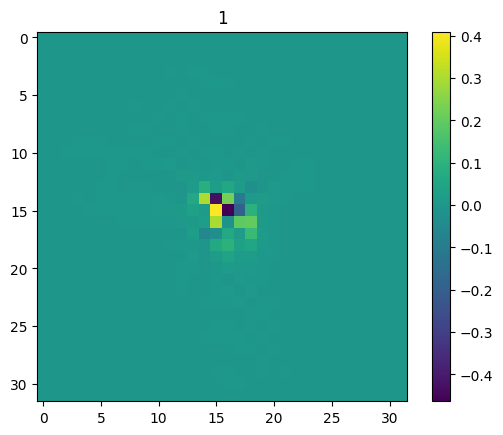

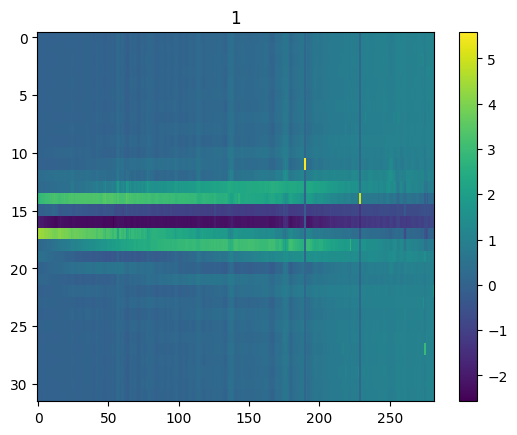

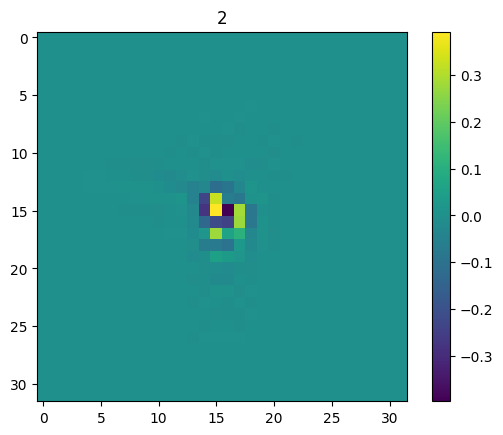

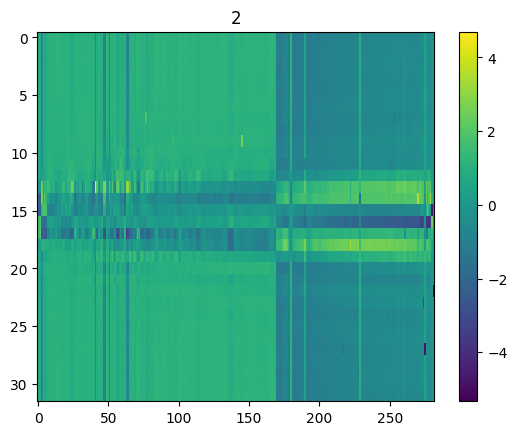

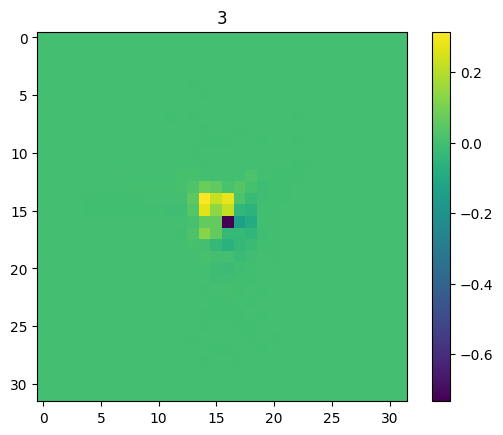

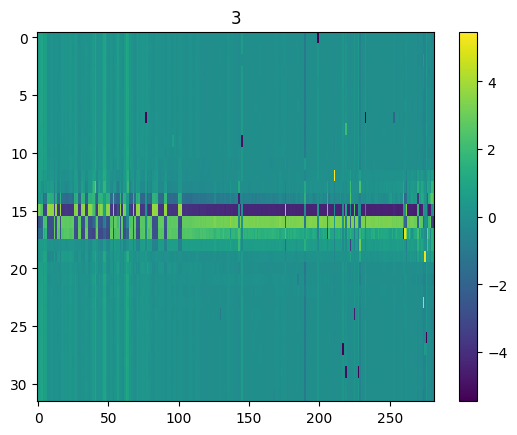

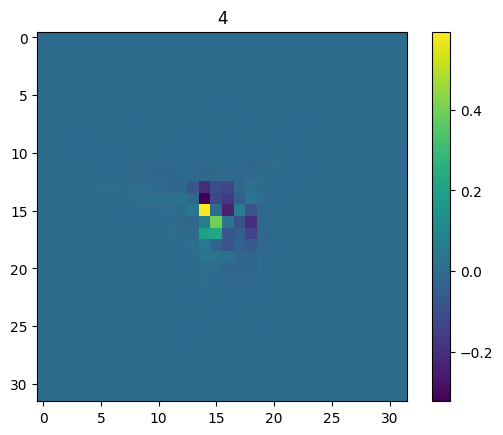

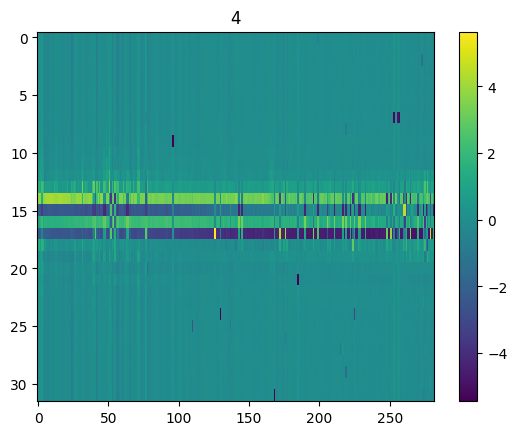

In [6]:
for ii in range(5):
    plt.figure()
    plt.imshow(components[0][ii].reshape(32,32).get())
    plt.title(ii)
    plt.colorbar()
    plt.figure()
    plt.imshow(np.stack([(c[ii]/kgs.rms(c[ii])*cp.sign(cp.mean(c[ii][0,10:20]))).get() for c in components[1:]])[:,0,:].T,aspect='auto',interpolation ='none')
    plt.title(ii)
    plt.colorbar()

In [7]:
n_components_use = [4]+[3]*282 # 4 verified for FGS, 3 for AIRS needs more consideration
kgs.sanity_checks_active = False
for iii,d in enumerate(train_data[0:10]):
    dd = copy.deepcopy(d)
    dd.transits = dd.transits[0:1]
    loader = ariel_load.default_loaders()
    for ii in range(2):
        loader[ii].apply_pixel_corrections.mask_dead= True
        loader[ii].apply_pixel_corrections.mask_hot = False
    dd.load_to_step(2, loader)
    residuals = []
    for i_wavelength in tqdm(range(0,283,1)):
        if i_wavelength==0:
            this_data = dd.transits[0].data[0].data.reshape(-1,1024)
        else:
            this_data = dd.transits[0].data[1].data[:,:,i_wavelength-1]
        n_removed=0
        noise_est = cp.ones(this_data.shape[1])
        for ii in range(this_data.shape[1]):
           noise_est[ii] = ariel_numerics.estimate_noise_cp(this_data[:,ii])
        noise_est[cp.isnan(noise_est)]=cp.nanmean(noise_est)
        noise_est[noise_est<10] = 10
        data_mean = cp.mean(this_data,0)
        for ii in range(this_data.shape[1]):
            if not cp.isnan(data_mean[ii]) and (data_mean[ii]<0 or noise_est[ii]>100*cp.sqrt(data_mean[ii])):
                print(i_wavelength, 'noise_est', noise_est[ii]/cp.sqrt(data_mean[ii]))
                this_data[:,ii] = cp.nan
                noise_est[ii] = cp.nan
        while True:            
            #this_data[:,15*32+15]=0
            #print(this_data.shape)
            data_mean = cp.mean(this_data,0)
            #print(data_mean.shape)
            design_matrix = cp.stack([cp.ones(data_mean.shape[0])]+[c[0,:] for c in components[i_wavelength][0:n_components_use[i_wavelength]]]).T#[
            #print(design_matrix.shape)            
            coeffs = ariel_numerics.lstsq_nanrows_normal_eq_with_pinv_sigma(data_mean[:,None], design_matrix, sigma=noise_est, return_A_pinv_w=False)
            residual = (data_mean[:,None]-design_matrix@coeffs[0])[:,0]
            residual_scaled = residual/noise_est*cp.sqrt(this_data.shape[0])
            residual_scaled[cp.isnan(residual_scaled)] = 0
            if cp.any(cp.abs(residual_scaled)>5):
                print(i_wavelength, cp.max(cp.abs(residual_scaled)))
                this_data[:,cp.argmax(cp.abs(residual_scaled))] = cp.nan
                noise_est[cp.argmax(cp.abs(residual_scaled))] = cp.nan
                n_removed+=1
            else:
                break
        if i_wavelength==0:
            print(coeffs[0][0])
        residuals.append(( residual  , noise_est, data_mean, n_removed ))
    del this_data, dd
    # plt.figure()
    # plt.imshow((residuals[0][0]).reshape(32,32).get())
    # plt.colorbar()
    # plt.figure()
    # plt.imshow((residuals[0][1]).reshape(32,32).get())
    # plt.colorbar()
    print(iii)
    plt.figure()
    plt.imshow((residuals[0][0]/residuals[0][1]*cp.sqrt(67500)).reshape(32,32).get())
    plt.colorbar()
    plt.figure()
    plt.imshow(cp.stack([r[0]/r[1]*cp.sqrt(5625) for r in residuals[1:]]).get().T, aspect='auto', interpolation='none')
    plt.colorbar()
    #plt.figure()
    #plt.clim([-10,10])
    # plt.imshow(cp.stack([r[0]/r[1]*cp.sqrt(5625) for r in residuals[1:]]).get().T, aspect='auto', interpolation='none')
    # plt.colorbar()
    # plt.clim([-10,10])
    vals = residuals[0][0]/residuals[0][1]*cp.sqrt(67500)
    print(np.nanpercentile(cp.abs(vals).get(),100))
    vals = cp.stack([r[0]/r[1]*cp.sqrt(5625) for r in residuals[1:]])
    print(np.nanpercentile(cp.abs(vals.flatten()).get(),100))
    plt.pause(0.001)

  1%|▉                                                                                  | 3/283 [00:03<04:08,  1.13it/s]

[-0.19677838]


 67%|██████████████████████████████████████████████████████                           | 189/283 [00:13<00:05, 17.45it/s]

186 5.54596973237684


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 274/283 [00:19<00:00, 14.28it/s]


KeyboardInterrupt: 

In [ ]:
# plt.figure()
# i_wavelength = 83
# dat = data_modes[1][:,:,i_wavelength]
# dat = dat - weights[i_wavelength+1][0]*components[i_wavelength+1][0]
# #dat = dat - weights[i_wavelength+1][1]*components[i_wavelength+1][1]
# plt.imshow(dat.get().T, aspect='auto', interpolation='none')
# plt.colorbar()
# #plt.figure()
# # plt.scatter([cp.mean(data_modes[1][ii,:,261]).get() for ii in range(data_modes[1].shape[0])],[cp.nanmean(data_modes[1][ii,15,261]).get() for ii in range(data_modes[1].shape[0])])
# # plt.figure()
# # plt.scatter([cp.mean(data_modes[1][ii,:,261]).get() for ii in range(data_modes[1].shape[0])],[cp.nanmean(data_modes[1][ii,16,261]).get() for ii in range(data_modes[1].shape[0])])
# #data_modes[1].shape

In [ ]:
### plt.figure()
plt.imshow(residuals[0][0].reshape(32,32).get())
plt.colorbar()
plt.figure()
plt.imshow(cp.log(residuals[0][1]).reshape(32,32).get()/np.log(10))
plt.colorbar()
plt.figure()
plt.imshow((residuals[0][1]/cp.sqrt(residuals[0][2])).reshape(32,32).get())
plt.colorbar()
plt.figure()
plt.imshow((residuals[0][0]/residuals[0][1]*cp.sqrt(67500)).reshape(32,32).get())
plt.colorbar()
vals = residuals[0][0]/residuals[0][1]*cp.sqrt(67500)
np.nanpercentile(cp.abs(vals).get(),100)
#plt.figure();plt.plot(vals.get())

In [ ]:
plt.figure()
plt.plot([r[3] for r in residuals[1:]])
plt.figure()
plt.imshow(cp.stack(r[0] for r in residuals[1:]).get().T, aspect='auto', interpolation='none')
plt.colorbar()
plt.figure()
plt.imshow(cp.log(cp.stack(r[1] for r in residuals[1:])).get().T/np.log(10), aspect='auto', interpolation='none')
plt.colorbar()
plt.figure()
plt.imshow(cp.log(cp.stack(r[2] for r in residuals[1:])).get().T/np.log(10), aspect='auto', interpolation='none')
plt.colorbar()
plt.figure()
plt.imshow((cp.stack(r[1]/cp.sqrt(r[2]) for r in residuals[1:])).get().T, aspect='auto', interpolation='none')
plt.colorbar()
plt.figure()
plt.imshow(cp.stack([r[0]/r[1]*cp.sqrt(5625) for r in residuals[1:]]).get().T, aspect='auto', interpolation='none')
plt.colorbar()
#plt.figure()
#plt.clim([-10,10])
# plt.imshow(cp.stack([r[0]/r[1]*cp.sqrt(5625) for r in residuals[1:]]).get().T, aspect='auto', interpolation='none')
# plt.colorbar()
# plt.clim([-10,10])
vals = cp.stack([r[0]/r[1]*cp.sqrt(5625) for r in residuals[1:]])
np.nanpercentile(cp.abs(vals.flatten()).get(),100)
#plt.figure();plt.semilogy(cp.sort(vals.flatten()).get())

In [ ]:
plt.figure()
plt.imshow(cp.isnan(residuals[0][0]).reshape(32,32).get())
plt.figure()
plt.imshow(np.isnan([r[0].get() for r in residuals[1:]]).T, aspect='auto', interpolation='none')

In [ ]:
import importlib
kgs.profiling=True
kgs.sanity_checks_active=False
importlib.reload(ariel_load)
importlib.reload(ariel_numerics)
loaders = ariel_load.default_loaders()
for ii in range(2):
    loaders[ii].apply_pixel_corrections.mask_dead = False
    loaders[ii].apply_pixel_corrections.mask_hot = False
    loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca = True
    loaders[ii].apply_full_sensor_corrections.inpainting_wavelength = False
    loaders[ii].apply_full_sensor_corrections.inpainting_2d = False
    loaders[ii].apply_full_sensor_corrections.remove_background_based_on_rows = False
    loaders[ii].apply_full_sensor_corrections.remove_background_based_on_pixels = False
dd = train_data[6]
dd.load_to_step(0,loaders)
dd.load_to_step(3,loaders)

print(cp.sum(cp.isnan(dd.transits[0].data[0].data)))

plt.figure()
plt.imshow(cp.isnan(dd.transits[0].data[0].data[0,...]).reshape(32,32).get())
plt.figure()
plt.imshow(cp.isnan(dd.transits[0].data[1].data[0,...]).get(), aspect='auto', interpolation='none')

In [ ]:
%debug

In [ ]:
dd.transits[0].data[1].data.shape

In [ ]:
dd.transits[0].data[0].data.shape